In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
import matplotlib.pyplot as plt

pt.set_default_tensor_type('torch.cuda.FloatTensor')
pd.set_option('display.max_rows', 500)

In [2]:
def collect_grad(coefs, loss):
    coef_labels = []
    coef_vals = []
    for key, val in coefs.items():
        coef_labels.append(key)
        coef_vals.append(val)

    coef_grads = pt.autograd.grad(loss, coef_vals)

    gradients = {}
    for coef_label, coef_grad in zip(coef_labels, coef_grads):
        gradients[coef_label] = coef_grad
        
    return gradients

In [3]:
dataset = pd.read_csv('data_files/market_data.csv')

In [4]:
working_data = pd.DataFrame(index = pd.date_range(dataset['record_date'].min(), dataset['record_date'].max())).join(
    dataset.set_index('record_date')['avg_price']
).fillna(method = 'ffill').fillna(method = 'bfill')['avg_price']

In [5]:
time_tensor = pt.from_numpy(working_data.values).type(pt.Tensor)

In [18]:
horizon = 1

coefs = {
    'level': pt.zeros(1)[0],
    'trend': pt.zeros(1)[0],
    'delta': pt.zeros(1)[0],
    'error_ratio': pt.zeros(1)[0]
}

grad = {}
grad_sq = {}

alpha = 0.2
beta = 0.1
clamp = 1e-16

loss_rcd = []

In [19]:
learn_rate = 1e-1
t = tqdm.tnrange(100)
for epoc in t:
    for coef in coefs.values(): coef.requires_grad = True
    
    coefs_sig = {}
    for coef_key, coef_val in coefs.items():
        if coef_key in ('error_ratio', 'delta'):
            #coefs_sig[coef_key] = pt.tanh(coef_val)
            continue
        else:
            coefs_sig[coef_key] = pt.sigmoid(coef_val)
        
    level = [time_tensor[0]]
    trend = [pt.zeros(1)[0]]
    error = [pt.zeros(1)[0]]
    
    for curr_val in time_tensor[1:]:
        
        new_level = (coefs_sig['level'] * curr_val) + ((1-coefs_sig['level']) * (level[-1] + trend[-1]))
        new_trend = (coefs_sig['trend'] * (new_level - level[-1])) + ((1-coefs_sig['trend']) * trend[-1])

        if len(error) >= horizon:
            predict = level[-horizon] + (horizon * trend[-horizon])
            new_error = curr_val - predict
        else:
            new_error = pt.zeros(1)[0]

        level.append(new_level)
        trend.append(new_trend)
        error.append(new_error)
        
    level = pt.stack(level)
    trend = pt.stack(trend)
    delta = pt.cat([pt.zeros(horizon), time_tensor[horizon:] - time_tensor[:-horizon]], dim=0)
    error = pt.stack(error)
    
    predict = (level + (horizon * trend)) + (coefs['error_ratio'] * error) + (coefs['delta'] * delta)
    loss = pt.sqrt(((time_tensor[horizon:] - predict[:-horizon]) ** 2).mean())
    loss_rcd.append(loss.detach().cpu().numpy())
    
    gradients = collect_grad(coefs, loss)
    
    with pt.no_grad():
        for coef_key, grad_val in gradients.items():
            grad[coef_key] = (alpha * grad_val) + ((1-alpha) * grad.get(coef_key, grad_val))
            grad_sq[coef_key] = (beta * (grad_val**2)) + ((1-alpha) * grad_sq.get(coef_key, grad_val**2))
            learn_step = grad[coef_key] / pt.clamp(pt.sqrt(grad_sq[coef_key]), clamp, np.inf)
            coefs[coef_key] = coefs[coef_key] - (learn_step * learn_rate)
            
    t.set_postfix({'loss': loss_rcd[-1]})

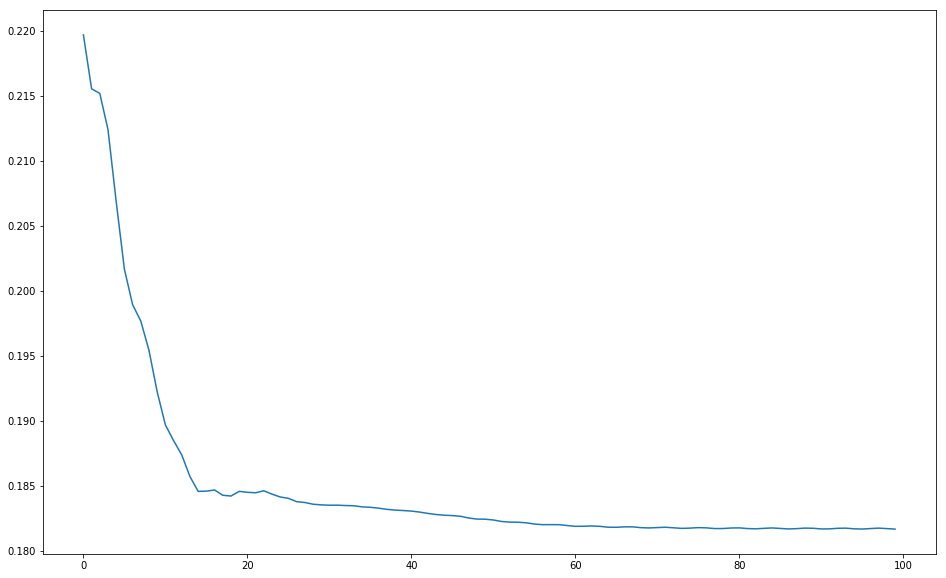

In [20]:
plt.figure(figsize=(16,10))
plt.plot(loss_rcd)

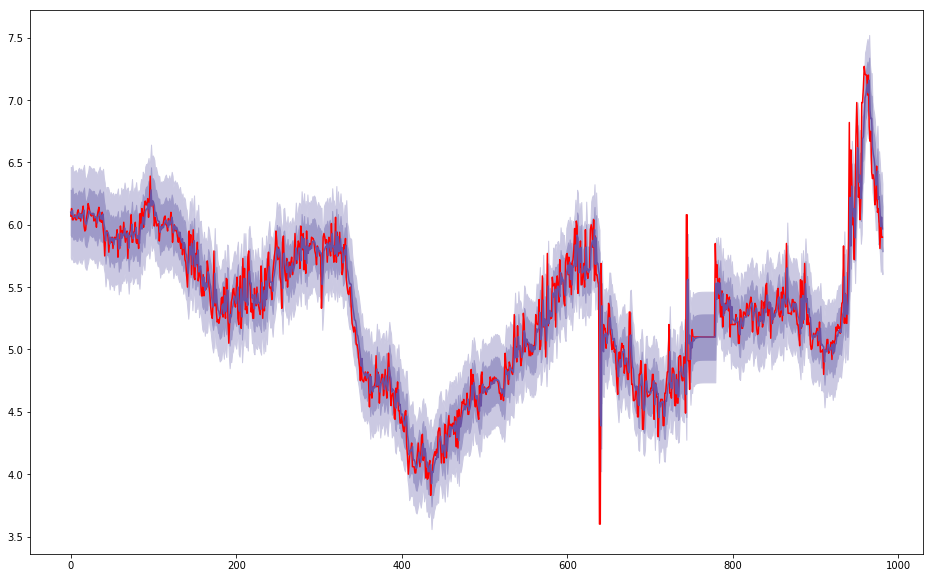

In [27]:
actuals = time_tensor[horizon:].detach().cpu().numpy()
predicts = predict[:-horizon].detach().cpu().numpy()
stdev = (actuals - predicts).std()

plt.figure(figsize=(16,10))
plt.plot(actuals, color = 'red', label = 'actual')
plt.plot(predicts, color='#6a51a3', label = 'predict')

plt.fill_between(
    range(predicts.shape[0]),
    predicts + (2 * stdev),
    predicts - (2 * stdev),
    color='#cbc9e2'
)

plt.fill_between(
    range(predicts.shape[0]),
    predicts + (1 * stdev),
    predicts - (1 * stdev),
    color='#9e9ac8'
)

In [24]:
for coef_key, coef_val in coefs.items():
    if coef_key in ('error_ratio', 'delta'):
        print('%s: %s' % (coef_key, coef_val))
    else:
        print('%s: %s' % (coef_key, pt.sigmoid(coef_val)))

level: tensor(0.3010)
trend: tensor(0.0000)
delta: tensor(0.1264)
error_ratio: tensor(0.1321)


mean error: -0.00026818668
stdev error: 0.18168049


/home/cherryj/conda/envs/standard/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


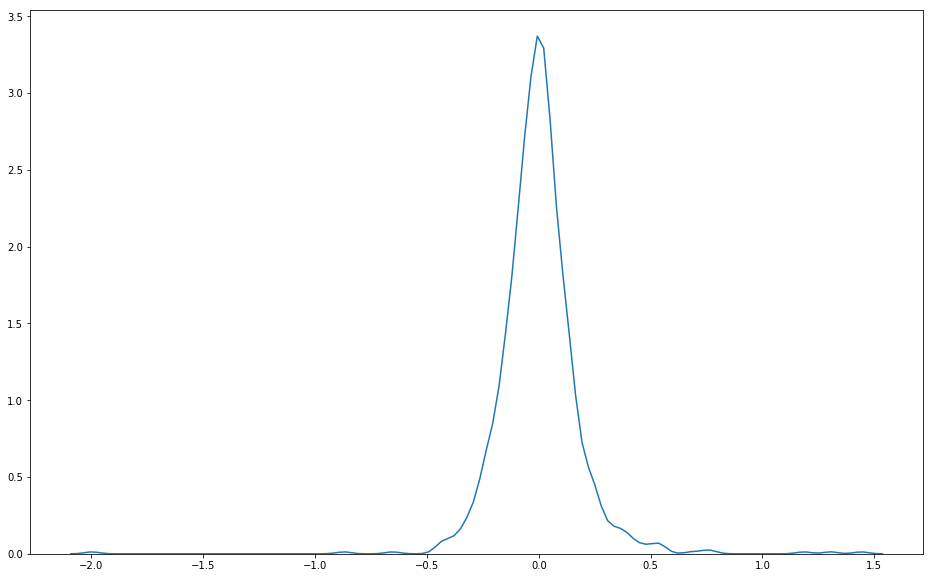

In [23]:
import seaborn as sns

error_data = (time_tensor[horizon:] - predict[:-horizon]).detach().cpu().numpy()

plt.figure(figsize=(16,10))
sns.kdeplot(error_data)
print('mean error:', error_data.mean())
print('stdev error:', error_data.std())